# STL Analysis
Our goal is a long-term investment strategy that manages risk. Because our goal is long-term, our 'volatility' measure should segregate seasonal components from trend and noise components. Noise is least important, seasonal patterns are somewhat important, and trend behavior is most important.

To understand the need for this current analysis, consider two stocks, Stock A and Stock B. Let's say stock A has very low volatility but also has steady, small returns. Stock B has very high seasonality and noise, but has trend behavior showing large returns. The standard utility function (returns - volatility or returns/volatility) might weight these two stocks as equally good choices. Stock A has less impressive returns but low volatility, while Stock B has very impressive returns but high volatility.

Let's now zoom in on Stock B. Yes, Stock B has high volatility, but we observe that this is due to seasonal trends and weekly flux. However, suppose the trend component is much less volatile. Then, for long-term purposes, why should we care about weekly noise and seasonal trends? Instead, we should decompose the volatility and weight the terms accordingly. This will lead to a better utility function while only adding, at most, a handful of extra hyperparameters.

In [1]:
import utils as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

data = u.log_diff(u.get_stock_data())

c:\Users\ttfee\OneDrive\Desktop\Stock Forecasting\utils.py:52: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index = df.index.to_period('D')


<Axes: >

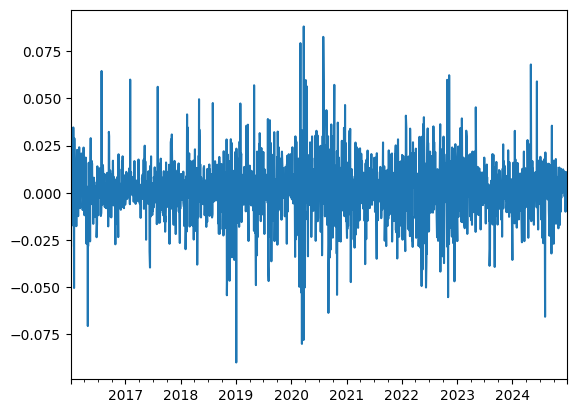

In [2]:
data['AAPL'].plot()

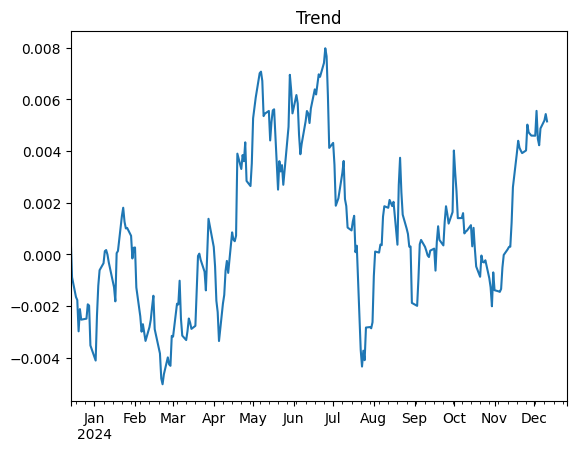

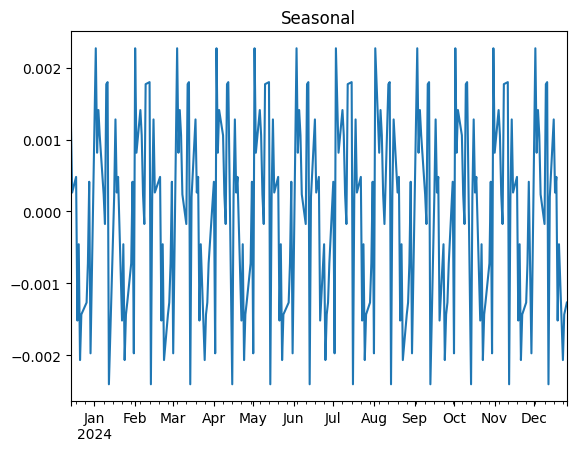

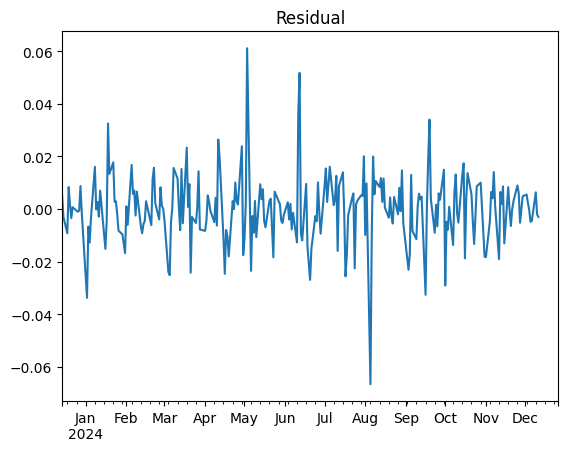

Total Variance:    0.00023848
Trend Variance:    0.00001443
Seasonal Variance: 0.00000182
Residual Variance: 0.00022229


In [3]:
stl = seasonal_decompose(data['AAPL'], period=21)

stl.trend[2000:2300].plot()
plt.title('Trend')
plt.show()
stl.seasonal[2000:2300].plot()
plt.title('Seasonal')
plt.show()
stl.resid[2000:2300].plot()
plt.title('Residual')
plt.show()

print(f"Total Variance:    {data['AAPL'].var():.8f}")
print(f'Trend Variance:    {stl.trend.var():.8f}')
print(f'Seasonal Variance: {stl.seasonal.var():.8f}')
print(f'Residual Variance: {stl.resid.var():.8f}')

(array([  6., 393., 216.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   2.]),
 array([  1.57210708,  10.27270822,  18.97330937,  27.67391051,
         36.37451165,  45.0751128 ,  53.77571394,  62.47631509,
         71.17691623,  79.87751737,  88.57811852,  97.27871966,
        105.97932081, 114.67992195, 123.38052309, 132.08112424,
        140.78172538, 149.48232653, 158.18292767, 166.88352881,
        175.58412996, 184.2847311 , 192.98533225, 201.68593339,
        210.38653453, 219.08713568, 227.78773682, 236.48833797,
        245.18893911, 253.88954025, 262.5901414 , 271.29074254,
        279.99134369, 288.69194483, 297.39254597, 306.09314712,
        314.79374826, 323.49434941, 332.19495055, 340.89555169,
        349.596152

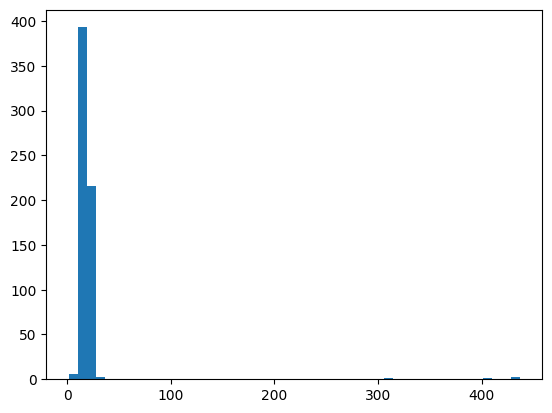

In [4]:
ratios = []
for col in data.columns:
    if len(data[col].dropna()) < 1000:
        continue
    stl = seasonal_decompose(data[col].dropna(), period=21)
    ratios.append(stl.resid.var() / stl.trend.var())

plt.hist(ratios, bins=50)

It looks like we have two outliers. Let's remove these.

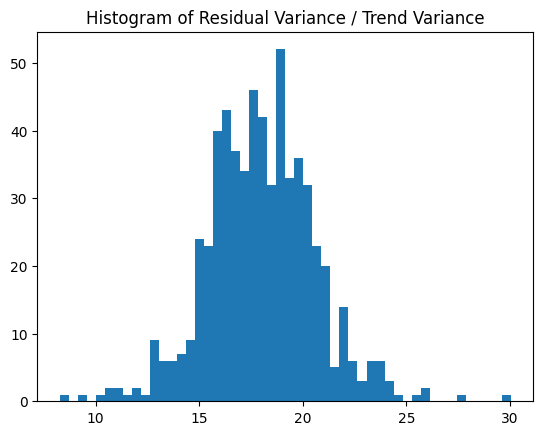

Stocks with Interesting Trend:
ATVI 1.7185022613128673
BHF 2.4755203101730157
BIIB 436.6021642776054
DNB 1.5721070780072521
DXCM 406.211173189856
INFO 433.9544929387992
MON 312.480322303822


In [5]:
fixed_ratios = [r for r in ratios if r < 50 and r >= 5]
plt.hist(fixed_ratios, bins=50)
plt.title('Histogram of Residual Variance / Trend Variance')
plt.show()

print("Stocks with Interesting Trend:")
for col in data.columns:
    if len(data[col].dropna()) < 1000:
        continue
    stl = seasonal_decompose(data[col].dropna(), period=21)
    r = stl.resid.var() / stl.trend.var()
    if r >= 50:
        print(col, r)
    if r < 5:
        print(col, r)

In [6]:
mean = np.mean(fixed_ratios)
std = np.std(fixed_ratios)
print(f'Mean: {mean:.3f}')
print(f'Std:  {std:.3f}')

Mean: 18.023
Std:  2.608


Wow, this is surprisingly close to a normal distribution.

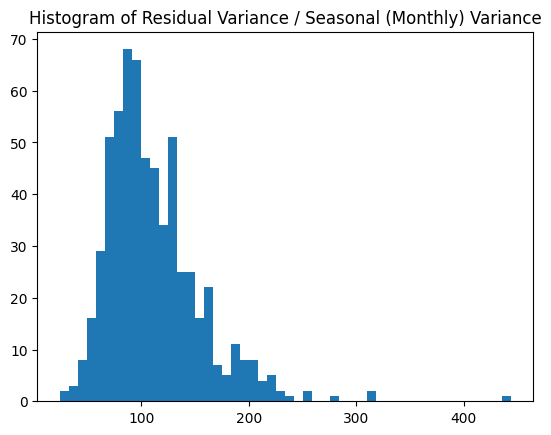

In [7]:
ratios = []
for col in data.columns:
    if len(data[col].dropna()) < 1000:
        continue
    stl = seasonal_decompose(data[col].dropna(), period=21)
    ratios.append(stl.resid.var() / stl.seasonal.var())

plt.hist(ratios, bins=50)
plt.title('Histogram of Residual Variance / Seasonal (Monthly) Variance')
plt.show()

In [8]:
print("Stocks with Low Seasonality:")
for col in data.columns:
    if len(data[col].dropna()) < 1000:
        continue
    stl = seasonal_decompose(data[col].dropna(), period=21)
    r = stl.resid.var() / stl.seasonal.var()
    if r > 300:
        print(col, r)

Stocks with Low Seasonality:
AMAT 443.8332636091682
KLAC 313.91566359324327
LRCX 309.8198531759427


Because the seasonal (monthly) variance is quite small relative to the noise, for all stocks, we will simply drop it from our penalty term.

AMAT 22.83213041942325
ATVI 58.93246570071753
BHF 32.67541633231962
DNB 43.457070451523556


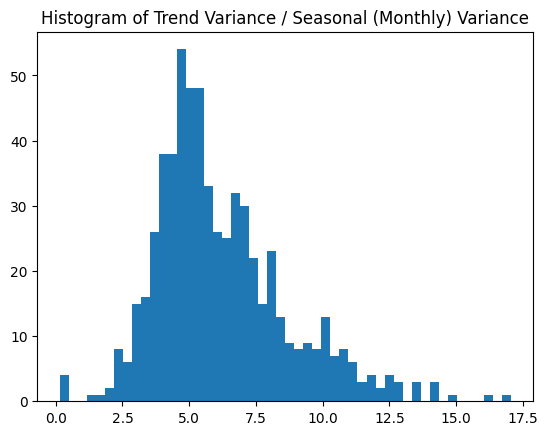

In [9]:
ratios = []
for col in data.columns:
    if len(data[col].dropna()) < 1000:
        continue
    stl = seasonal_decompose(data[col].dropna(), period=21)
    r = stl.trend.var() / stl.seasonal.var()
    if r > 20:
        print(col, r)
        continue
    ratios.append(r)

plt.hist(ratios, bins=50)
plt.title('Histogram of Trend Variance / Seasonal (Monthly) Variance')
plt.show()

In [10]:
print("Stocks with Low Seasonality relative to Trend:")
for col in data.columns:
    if len(data[col].dropna()) < 1000:
        continue
    stl = seasonal_decompose(data[col].dropna(), period=21)
    r = stl.trend.var() / stl.seasonal.var()
    if r > 15:
        print(col, r)

Stocks with Low Seasonality relative to Trend:
AMAT 22.83213041942325
ATVI 58.93246570071753
BHF 32.67541633231962
CTAS 17.05070009190234
DNB 43.457070451523556
LRCX 16.08593842708824


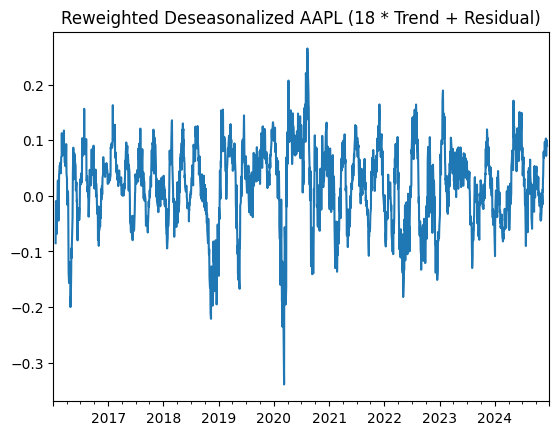

In [11]:
decomp = u.Decomposition(data)
reweighted = decomp.weighted_deseasonalized()
reweighted['AAPL'].plot()
plt.title('Reweighted Deseasonalized AAPL (18 * Trend + Residual)')
plt.show()

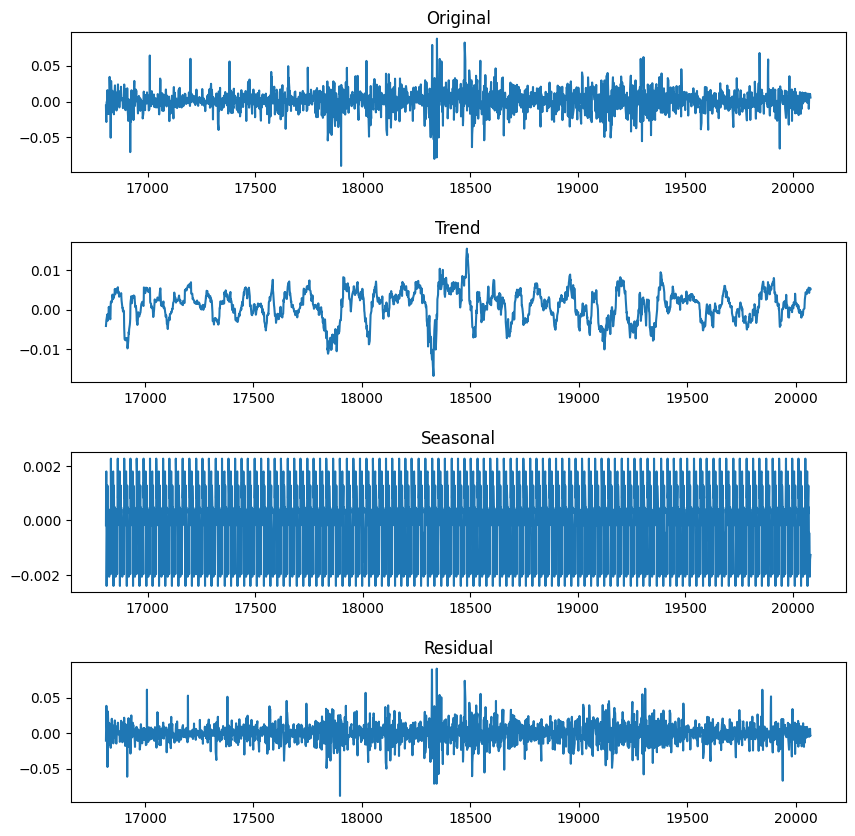

In [12]:
decomp.plot()